## Trend-following Effect in Stocks

* 投資範圍設定：投資範圍包括100支最具流動性的股票，且股價不小於新台幣50元。
* 入場條件：如果今天的收盤價高於或等於該股票十年內的最高收盤價，或是三天內漲幅達5%，則發出入場信號。
* 出場條件：使用10期的平均真實範圍（ATR）作為跟蹤停損信號。當股票的價格低於當前價格減去ATR時，執行出場。
* 持倉管理：投資者持有所有符合入場條件且未被停損的股票。組合等權重，每日重新平衡。
* 交易成本：台灣手續費模型

這個策略的目標是捕捉股票市場中的趨勢，通過在股價上揚力道強勁時入場，並使用ATR作為跟蹤停損來控制風險。

In [1]:
import os
import tejapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# os.environ['TEJAPI_KEY'] = "your key"
# os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = "VQZyPSb1cxDuftfxpq4ZJcs0KZenR1"
os.environ['TEJAPI_BASE'] = "http://10.10.10.66"
start = '2021-04-01'
end = '2024-04-01'

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e=['Common Stock-Foreign', 'Common Stock'])
len(pool)

Currently used TEJ API key call quota 1295/100000 (1.29%)
Currently used TEJ API key data quota 66603431/10000000 (666.03%)


1859

In [3]:
import TejToolAPI
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')

df = TejToolAPI.get_history_data(start = start_dt,
                                   end = end_dt,
                                   ticker = pool,
                                   columns = ['Volume_1000_Shares', 'Low'],
                                   transfer_to_chinese = False)

df

Currently used TEJ API key call quota 1407/100000 (1.41%)
Currently used TEJ API key data quota 70798885/10000000 (707.99%)


,coid,mdate,Volume_1000_Shares,Low
0,1101,2021-04-01,16542.0,46.60
1,1101,2021-04-06,33845.0,46.60
2,1101,2021-04-07,12964.0,46.70
3,1101,2021-04-08,16095.0,46.60
4,1101,2021-04-09,19693.0,46.70
...,...,...,...,...
1294833,9962,2024-03-26,336.0,17.45
1294834,9962,2024-03-27,413.0,17.60
1294835,9962,2024-03-28,300.0,17.80
1294836,9962,2024-03-29,322.0,17.85


In [5]:
average_vol = df.groupby('coid')['Volume_1000_Shares'].mean().reset_index()
average_vol = average_vol.rename(columns={'Volume_1000_Shares': 'Avg_vol'})
high_price_stocks = df.groupby('coid')['Low'].min().reset_index()
high_price_stocks = high_price_stocks[high_price_stocks['Low'] >= 50]
merge_data = pd.merge(average_vol, high_price_stocks, on='coid', how='inner')
top_100_vol = merge_data.sort_values(by='Avg_vol', ascending=False).head(100)
top_100_vol

,coid,Avg_vol,Low
53,2317,36844.357045,94.0
55,2330,33026.872777,370.0
118,3037,30062.634747,84.6
117,3035,24662.682627,51.8
65,2382,23015.292750,66.2
...,...,...,...
217,4763,2592.904241,88.0
88,2645,2574.371094,84.1
267,6176,2549.879617,81.1
322,6533,2528.311902,225.0


In [7]:
new_pool = top_100_vol['coid'].to_list()
new_tickers = ' '.join(new_pool)

start = '2014-04-01'
end = '2024-04-01'
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')
os.environ['ticker'] = ''.join(new_tickers) +' IX0001'
os.environ['mdate'] = start+' '+end

In [8]:
!zipline ingest -b tquant

[2024-04-17 09:30:15.818228] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]     
Currently used TEJ API key call quota 1418/100000 (1.42%)
Currently used TEJ API key data quota 71480743/10000000 (714.81%)
[2024-04-17 09:32:31.079643] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [9]:
 !zipline bundle-info

tickers :
1216 1301 1303 1326 1560 1722 1760 1795 2301 2308
2317 2327 2330 2345 2351 2357 2376 2377 2379 2382
2383 2385 2412 2454 2455 2456 2458 2474 2492 2636
2645 3006 3014 3016 3017 3019 3034 3035 3037 3042
3044 3045 3105 3169 3189 3324 3362 3374 3406 3443
3491 3504 3532 3545 3558 3583 3596 3661 3711 4162
4721 4739 4743 4763 4904 4919 4938 4958 4961 4968
5347 5388 5483 5871 6138 6176 6187 6213 6223 6239
6271 6278 6285 6411 6485 6505 6531 6533 6547 6550
6589 6806 8016 8046 8069 8086 8210 8261 8299 9958
IX0001 
start_date : 20140401.
end_date : 20240401.


In [10]:
from zipline.pipeline.factors import TrueRange, CustomFactor
from zipline.utils.math_utils import nanmax
from numpy import dstack
from zipline.pipeline.data import TWEquityPricing, EquityPricing
from zipline.pipeline.factors import CustomFactor

class AverageTrueRange(CustomFactor):

    inputs = (
        EquityPricing.high,
        EquityPricing.low,
        EquityPricing.close,
    )
    
    window_length = 10

    outputs = ["TR", "ATR"]
    
    def compute(self, today, assets, out, highs, lows, closes):

        high_to_low = highs[1:] - lows[1:]
        high_to_prev_close = abs(highs[1:] - closes[:-1])
        low_to_prev_close = abs(lows[1:] - closes[:-1])
        tr_current = nanmax(
            dstack(
                (
                    high_to_low,
                    high_to_prev_close,
                    low_to_prev_close,
                )
            ),
            2,
        )

        sma_atr_values = np.mean(tr_current, axis=0)
        
        out.TR = tr_current[-1]
        out.ATR = sma_atr_values

class N_Year_Highest(CustomFactor):

    inputs = EquityPricing.high

    window_length = 100

    def compute(self, today, assets, out, highs):
    
        out[:] = np.nanmax(highs[0:int(self.window_length)-1], axis=0)

class Large_Rise(CustomFactor):

    inputs = EquityPricing.close

    window_length = 3

    def compute(self, today, assets, out, close):
        
        out[:] = (np.nanmean(close[int(self.window_length)-1:self.window_length], axis=0) - np.nanmean(close[0:1], axis=0))\
        / np.nanmean(close[int(self.window_length)-1:self.window_length], axis=0)

In [11]:
from zipline.pipeline.filters import StaticAssets
from zipline.data import bundles
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IX0001',as_of_date = None)

In [12]:
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
def make_pipeline():
    curr_price = TWEquityPricing.close.latest
    ATR = AverageTrueRange(inputs = [TWEquityPricing.high,
                                 TWEquityPricing.low,
                                 TWEquityPricing.close])
    highest_price = N_Year_Highest(inputs = [TWEquityPricing.high])
    rise = Large_Rise(inputs = [TWEquityPricing.close], window_length = 3)
    
    return Pipeline(
        columns = {
            'curr_price': curr_price,
            'highest_price': highest_price,
            'Rise': rise,
            'stop_loss': ATR.ATR,
    },
        screen = ~StaticAssets([benchmark_asset])
    )
my_pipeline = run_pipeline(make_pipeline(), start_dt, end_dt)
my_pipeline

curr_price  highest_price  \
2014-04-02 00:00:00+00:00 Equity(0 [1216])         51.8            NaN   
                          Equity(1 [1301])         76.3            NaN   
                          Equity(2 [1303])         64.1            NaN   
                          Equity(3 [1326])         73.4            NaN   
                          Equity(4 [1560])         96.1            NaN   
...                                                 ...            ...   
2024-04-01 00:00:00+00:00 Equity(95 [8086])       144.0          165.0   
                          Equity(96 [8210])       255.0          323.0   
                          Equity(97 [8261])        87.0          108.5   
                          Equity(98 [8299])       708.0          703.0   
                          Equity(99 [9958])       218.5          268.0   

                                                 Rise  stop_loss  
2014-04-02 00:00:00+00:00 Equity(0 [1216])        NaN        NaN  
                          Equity(1 [1301])        NaN        NaN  
                          Equity(2 [1303])        NaN        NaN  
                          Equity(3 [1326])        NaN        NaN  
                          Equity(4 [1560])        NaN        NaN  
...                                               ...        ...  
2024-04-01 00:00:00+00:00 Equity(95 [8086]) -0.024306   7.388889  
                          Equity(96 [8210])  0.009804  11.611111  
                          Equity(97 [8261])  0.027586   1.811111  
                          Equity(98 [8299])  0.042373  32.111111  
                          Equity(99 [9958]) -0.013730  13.388889  

[229713 rows x 4 columns]

In [13]:
from zipline.finance import slippage, commission
from zipline.api import *

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    attach_pipeline(make_pipeline(), 'mystrats')
    set_benchmark(symbol('IX0001'))
    context.stop_loss = {}

In [14]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')

    for i in out_dir.index:
        curr_price = out_dir.loc[i, 'curr_price']
        highest = out_dir.loc[i, 'highest_price']
        rise = out_dir.loc[i, 'Rise']
        atr = out_dir.loc[i, 'stop_loss']
        
        cash_position = context.portfolio.cash  # record cash position
        stock_position = context.portfolio.positions[i].amount  # record stock holding

        if context.stop_loss.get(f'{i}') is None:
            context.stop_loss[f'{i}'] = 0
        
        # buy
        if (curr_price > context.stop_loss.get(f'{i}')) & (atr is not None) & (cash_position > 0):
            if (curr_price >= highest) | (rise >= 0.05):
                order_percent(i, 0.03)
                context.stop_loss[f'{i}'] = curr_price - (0.8 * atr)

        # stop loss
        if (curr_price <= context.stop_loss[f'{i}']) and (stock_position > 0):
            order_target(i, 0)

In [15]:
def analyze(context, perf):
    pass

In [16]:
from zipline import run_algorithm
start = '2019-04-01'
end = '2024-04-01'
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')

results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize = initialize,
    bundle = 'tquant',
    analyze = analyze,
    capital_base = 1e6,
    handle_data = handle_data
)

results

,period_open,period_close,ending_exposure,starting_cash,shorts_count,ending_value,ending_cash,returns,benchmark_return,net_leverage,...,benchmark_period_return,excess_return,benchmark_volatility,treasury_period_return,trading_days,sharpe,max_drawdown,period_label,alpha,beta
2019-04-01 13:30:00+08:00,2019-04-01 09:01:00+08:00,2019-04-01 13:30:00+08:00,0.00,1.000000e+06,0,0.00,1.000000e+06,0.000000,0.000149,0.000000,...,0.000149,-0.000149,NaN,0.0,1,NaN,0.000000,2019-04,NaN,NaN
2019-04-02 13:30:00+08:00,2019-04-02 09:01:00+08:00,2019-04-02 13:30:00+08:00,304387.90,1.000000e+06,0,304387.90,6.951751e+05,-0.000437,0.004479,0.304521,...,0.004629,-0.005066,0.048601,0.0,2,-11.224972,-0.000437,2019-04,0.003808,-0.100930
2019-04-03 13:30:00+08:00,2019-04-03 09:01:00+08:00,2019-04-03 13:30:00+08:00,545746.40,6.951751e+05,0,545746.40,4.524232e+05,-0.001394,0.001317,0.546747,...,0.005952,-0.007783,0.035561,0.0,3,-13.589026,-0.001830,2019-04,-0.135546,-0.016397
2019-04-08 13:30:00+08:00,2019-04-08 09:01:00+08:00,2019-04-08 13:30:00+08:00,1009929.75,4.524232e+05,0,1009929.75,-1.235752e+03,0.010544,0.008986,1.001225,...,0.014992,-0.006298,0.062719,0.0,4,6.166479,-0.001830,2019-04,-0.465043,1.247683
2019-04-09 13:30:00+08:00,2019-04-09 09:01:00+08:00,2019-04-09 13:30:00+08:00,1005765.80,-1.235752e+03,0,1005765.80,-1.235752e+03,-0.004128,0.004725,1.001230,...,0.019788,-0.015257,0.054771,0.0,5,2.592008,-0.004128,2019-04,-0.586048,1.121979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 13:30:00+08:00,2024-03-26 09:01:00+08:00,2024-03-26 13:30:00+08:00,5046832.70,4.181708e+05,0,5046832.70,9.281867e+05,-0.020303,-0.003257,0.844655,...,0.891403,4.083617,0.169330,0.0,1215,1.387617,-0.308279,2024-03,0.351549,0.781988
2024-03-27 13:30:00+08:00,2024-03-27 09:01:00+08:00,2024-03-27 13:30:00+08:00,4282104.80,9.281867e+05,0,4282104.80,1.788626e+06,0.016019,0.003658,0.705369,...,0.898322,4.172409,0.169266,0.0,1216,1.397791,-0.308279,2024-03,0.354847,0.782254
2024-03-28 13:30:00+08:00,2024-03-28 09:01:00+08:00,2024-03-28 13:30:00+08:00,3055848.80,1.788626e+06,0,3055848.80,3.047949e+06,0.005447,-0.002652,0.500647,...,0.893288,4.210510,0.169203,0.0,1217,1.400957,-0.308279,2024-03,0.356647,0.782106
2024-03-29 13:30:00+08:00,2024-03-29 09:01:00+08:00,2024-03-29 13:30:00+08:00,3201244.50,3.047949e+06,0,3201244.50,2.855648e+06,-0.007685,0.007341,0.528529,...,0.907187,4.149705,0.169161,0.0,1218,1.394934,-0.308279,2024-03,0.352693,0.781391


In [17]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return']

Start date,2019-04-01
End date,2024-04-01
Total months,58
,Backtest
Annual return,45.286%
Cumulative returns,509.151%
Annual volatility,29.945%
Sharpe ratio,1.40
Calmar ratio,1.47
Stability,0.82
Max drawdown,-30.828%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.83,2021-12-28,2022-10-25,2023-07-24,378
1,29.75,2021-07-08,2021-10-04,2021-11-30,101
2,24.16,2021-04-08,2021-05-12,2021-06-15,47
3,23.60,2019-10-30,2020-03-24,2020-06-03,144
4,19.53,2020-07-09,2020-11-02,2020-12-25,119


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.17%,-9.86%,7.04%


Top 10 long positions of all time,max
sid,
4968,59.94%
6531,43.24%
2636,42.77%
6239,38.40%
3017,36.80%
6187,32.27%
3558,29.75%
3045,29.61%
4763,28.29%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
4968,59.94%
6531,43.24%
2636,42.77%
6239,38.40%
3017,36.80%
6187,32.27%
3558,29.75%
3045,29.61%
4763,28.29%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


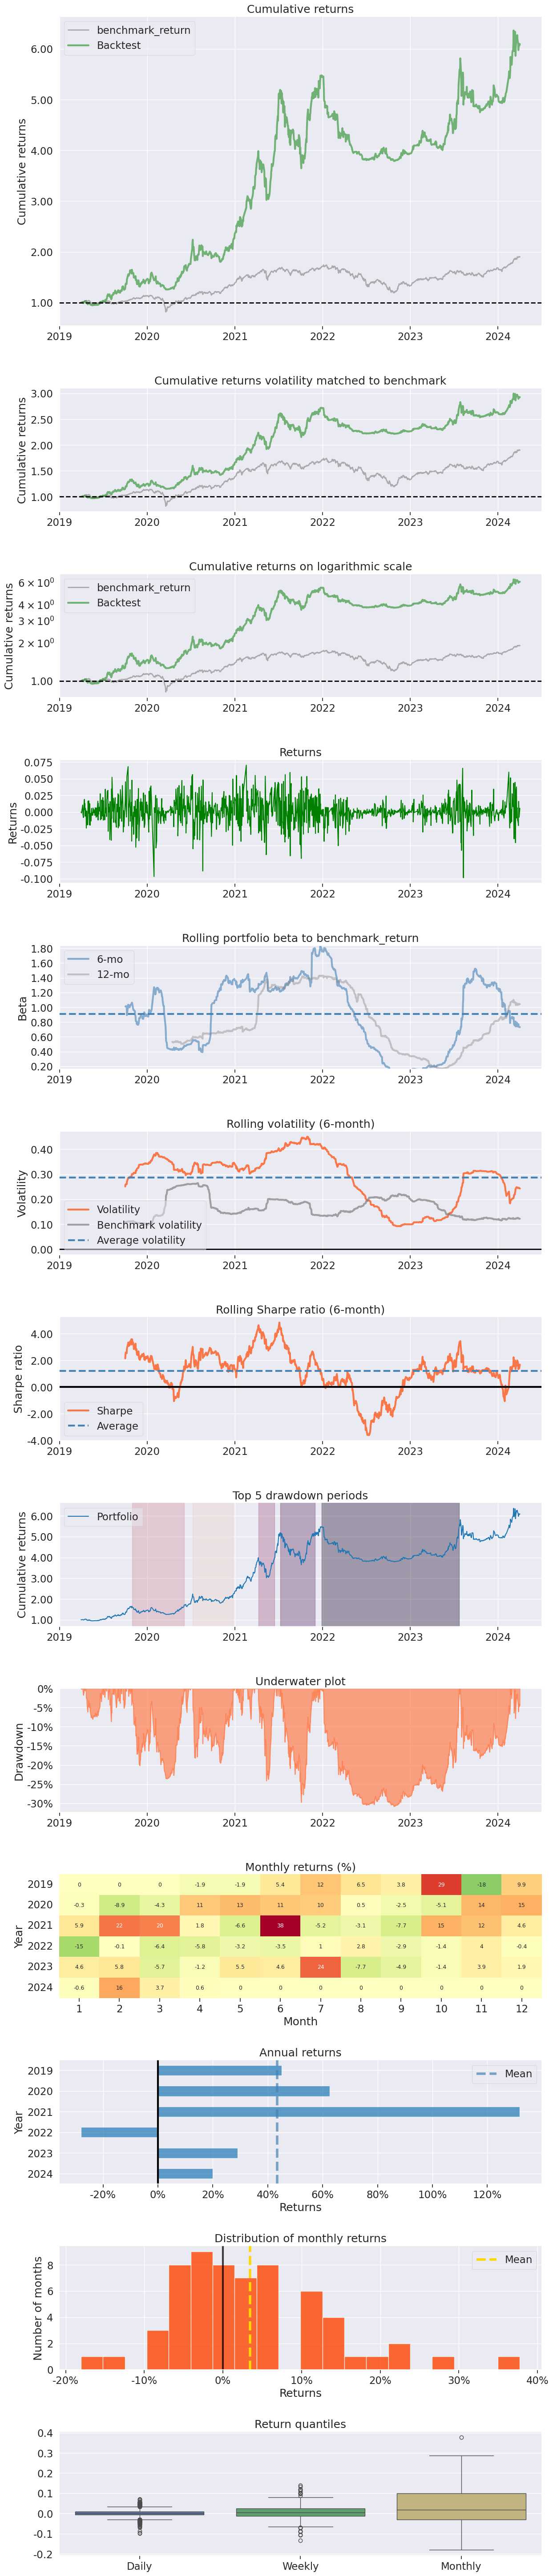

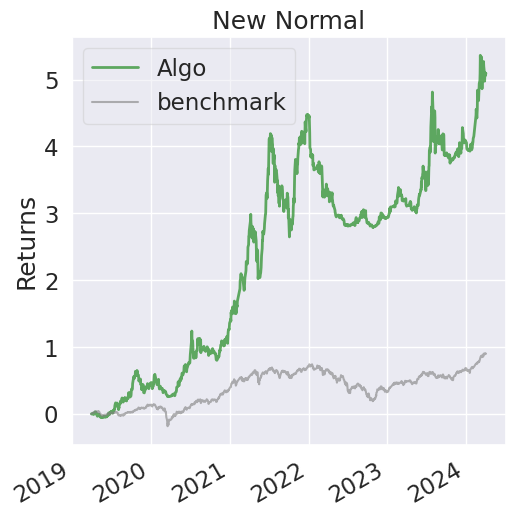

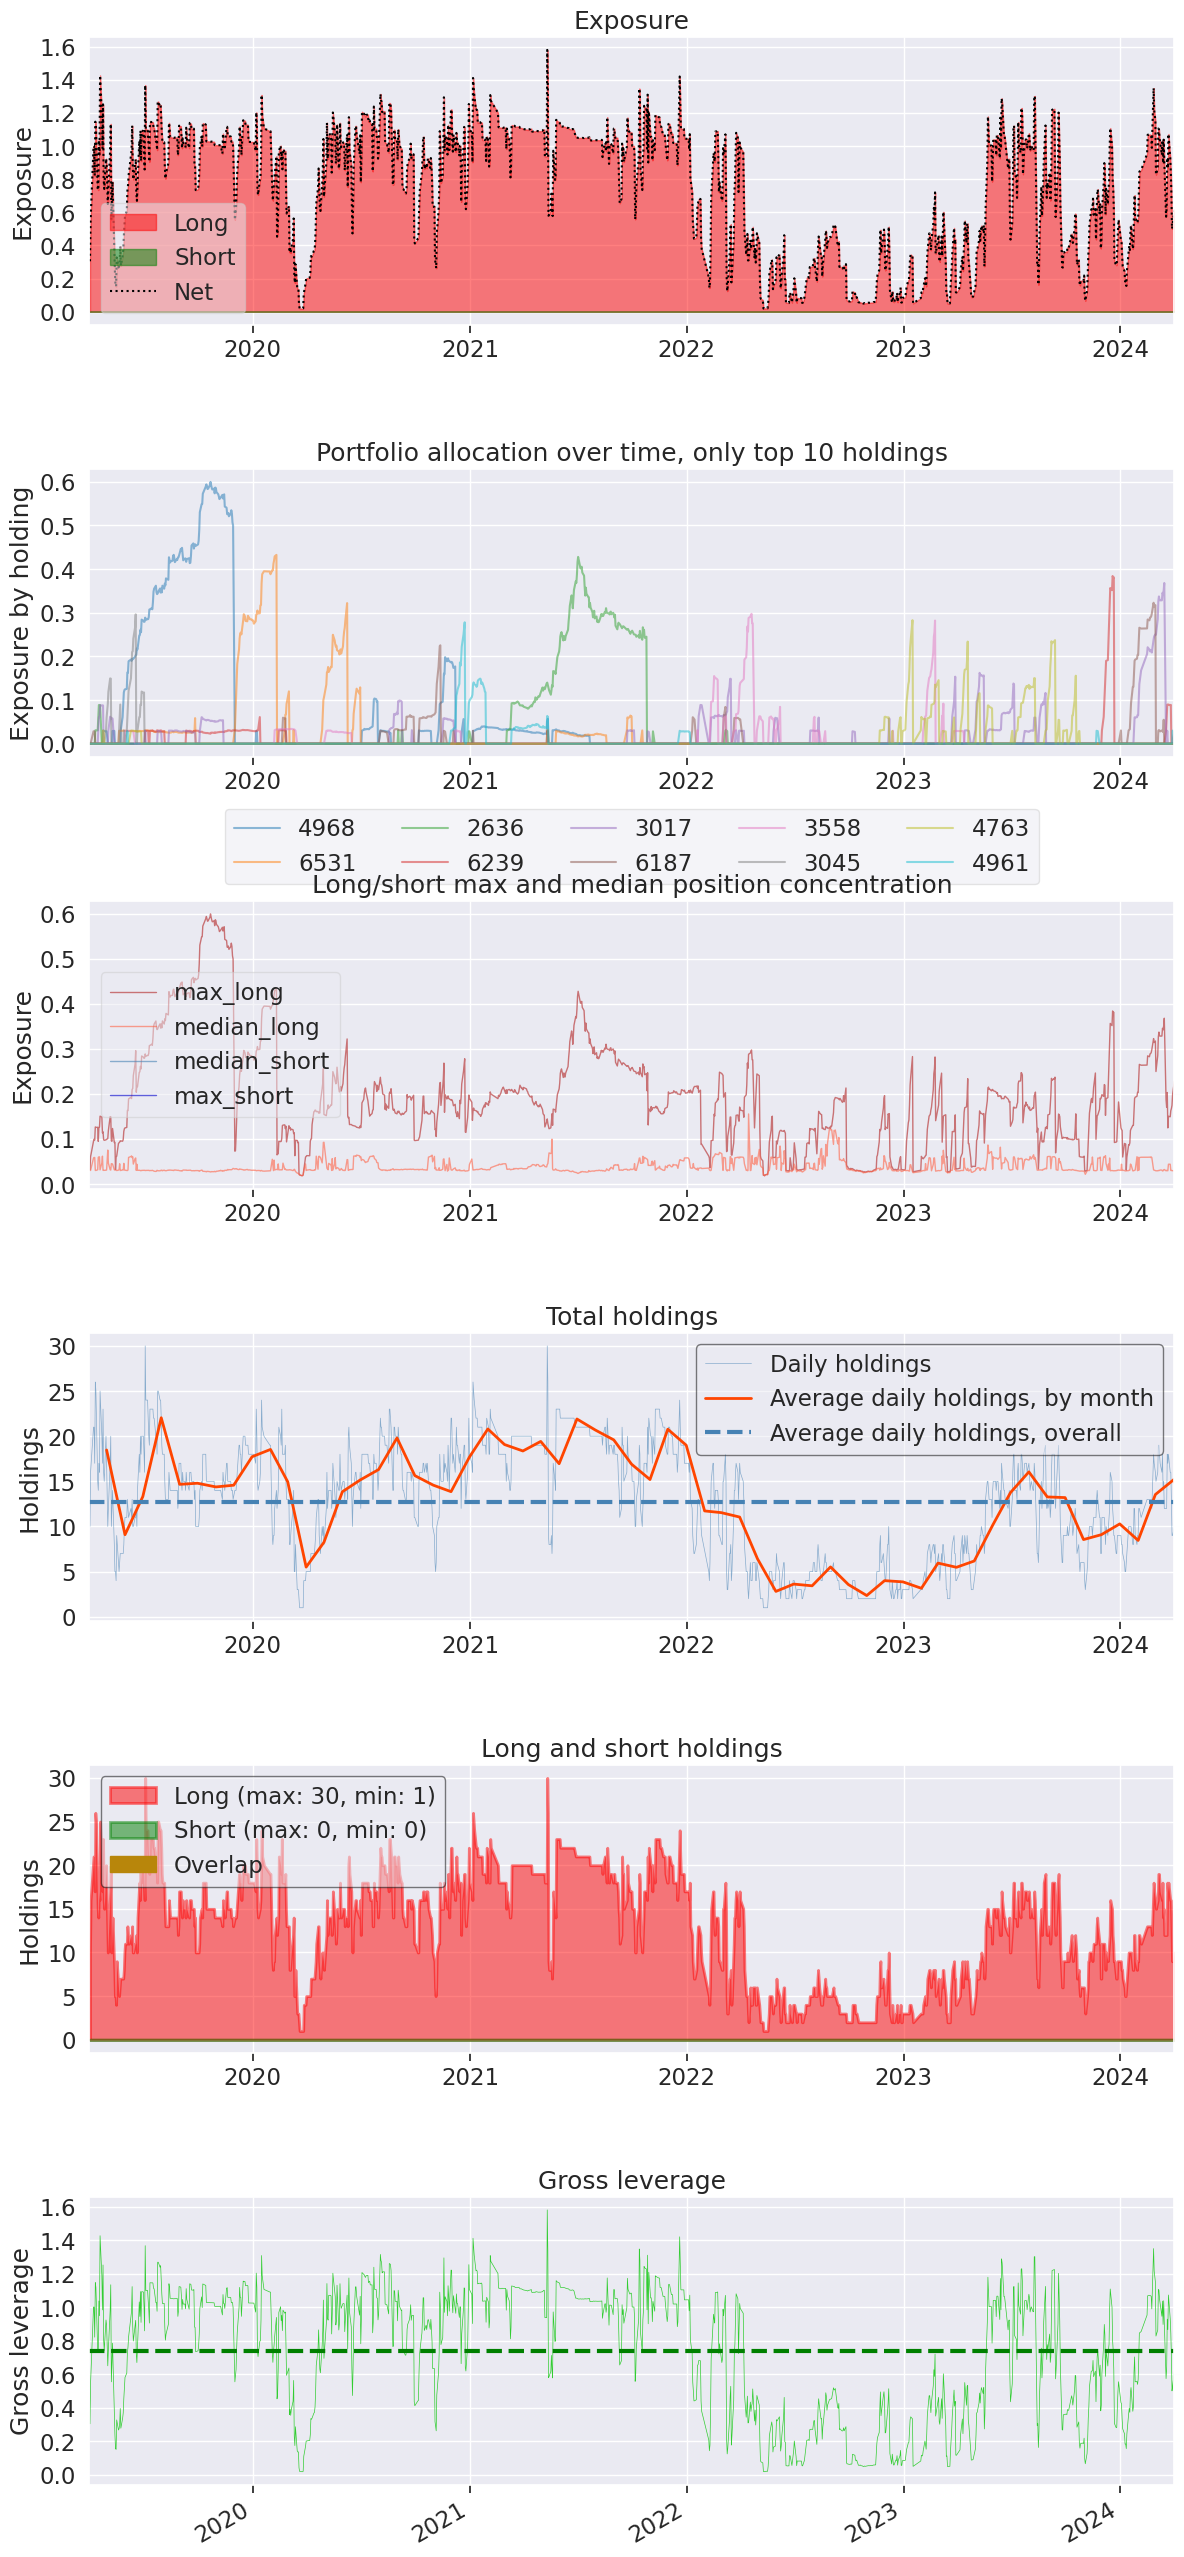

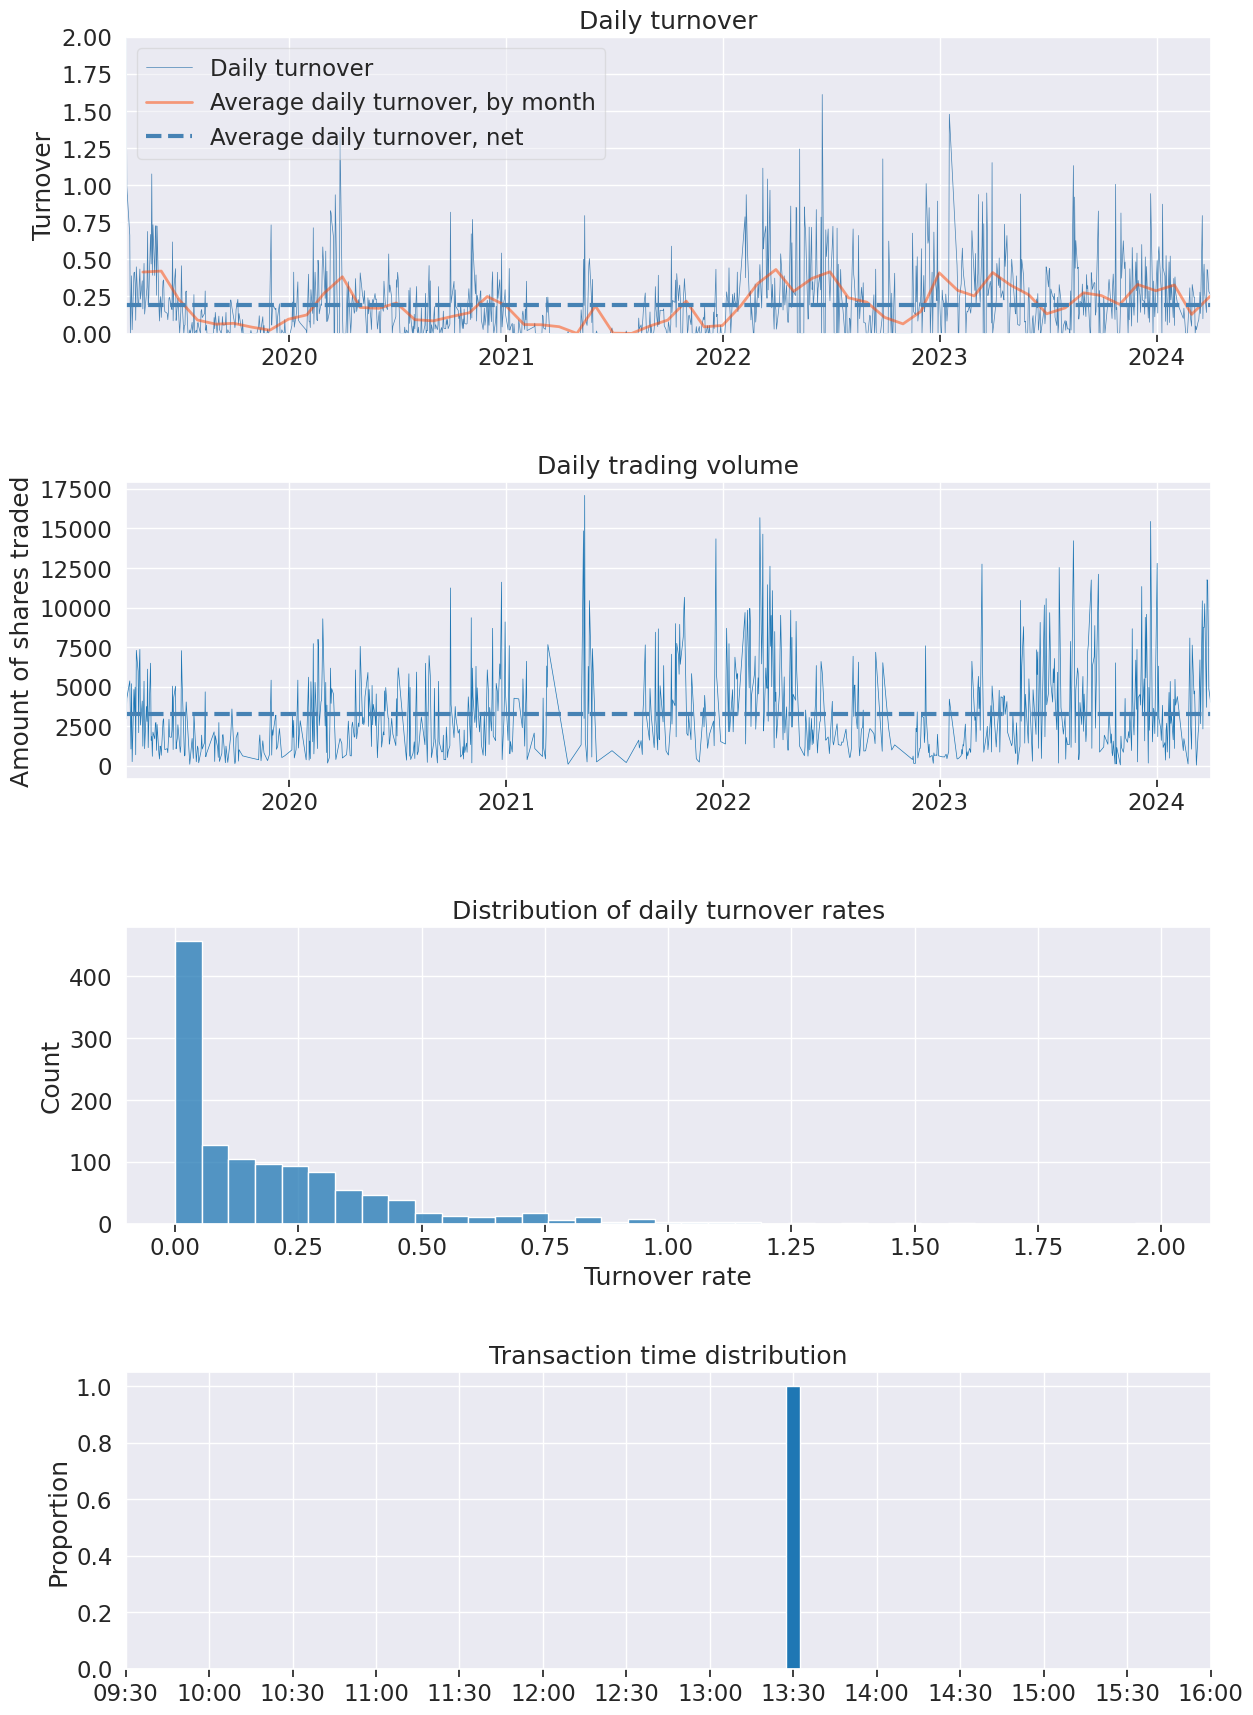

In [18]:
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )